### Exact solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('Allen_Cahn.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['u']

# # Use the loaded variables as needed
# print(x.shape)
# print(t.shape)
# print(u.shape)

# X, T = np.meshgrid(x, t)
# # Define custom color levels
# c_levels = np.linspace(np.min(u), np.max(u), 100)

# # Plot the contour
# plt.figure()
# plt.figure(figsize=(15, 5))
# plt.contourf(T, X, u, levels=c_levels, cmap='coolwarm')
# plt.xlabel('t')
# plt.ylabel('x')
# plt.title('Allen-cahn-Equation')
# plt.colorbar()  # Add a colorbar for the contour levels
# plt.show()

### PINN data importing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('X.mat')

X = mat_data['X']

mat_data1 = scipy.io.loadmat('y_pred.mat')

u1 = mat_data1['y_pred']

np.set_printoptions(threshold=np.inf)

X.shape

(20301, 2)

In [3]:
### Reshaping the solution

u1 = u1.reshape(101, 201)
u1_new = u1.T


In [4]:
u1_new.shape

(201, 101)

In [5]:
# Load the .mat file
mat_data2 = scipy.io.loadmat('y_true.mat')

u2 = mat_data2['y_true']
print("tani", u2.shape)


tani (20301, 1)


In [6]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [7]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [9]:
# Toy problem data
input_size = 201  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 201
sequence_length = 80  # number of sequences/ number of rows
batch_size = 1
num_epochs = 20000

In [10]:
# data = scipy.io.loadmat('y_pred.mat')
u1 = u1_new


In [11]:
input_data = u1[:, 0:80]
target_data = u1[:, 1:81]

test_data = u1[:, 80] ### Change here
#test_target = u1[:, 81:101]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (201,)
input data shape (201, 80)
Target data shape (201, 80)


In [12]:
# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 80, 201])
Target tensor shape torch.Size([1, 80, 201])


In [13]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()


In [14]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.16f}')

Epoch: 10/20000, Loss: 0.4047427177429199
Epoch: 20/20000, Loss: 0.3674259185791016
Epoch: 30/20000, Loss: 0.3271979987621307
Epoch: 40/20000, Loss: 0.2872202098369598
Epoch: 50/20000, Loss: 0.2505701780319214
Epoch: 60/20000, Loss: 0.2182461768388748
Epoch: 70/20000, Loss: 0.1906850636005402
Epoch: 80/20000, Loss: 0.1673887223005295


/data/localhome/tkapoor/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 80, 201])) that is different to the input size (torch.Size([80, 201])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 90/20000, Loss: 0.1479588150978088
Epoch: 100/20000, Loss: 0.1316629201173782
Epoch: 110/20000, Loss: 0.1178707554936409
Epoch: 120/20000, Loss: 0.1061105057597160
Epoch: 130/20000, Loss: 0.0960263684391975
Epoch: 140/20000, Loss: 0.0873415321111679
Epoch: 150/20000, Loss: 0.0798336938023567
Epoch: 160/20000, Loss: 0.0733141750097275
Epoch: 170/20000, Loss: 0.0675948485732079
Epoch: 180/20000, Loss: 0.0624248050153255
Epoch: 190/20000, Loss: 0.0576975755393505
Epoch: 200/20000, Loss: 0.0532994493842125
Epoch: 210/20000, Loss: 0.0492991954088211
Epoch: 220/20000, Loss: 0.0457226485013962
Epoch: 230/20000, Loss: 0.0424895472824574
Epoch: 240/20000, Loss: 0.0395416505634785
Epoch: 250/20000, Loss: 0.0368363931775093
Epoch: 260/20000, Loss: 0.0343484655022621
Epoch: 270/20000, Loss: 0.0320536457002163
Epoch: 280/20000, Loss: 0.0299359634518623
Epoch: 290/20000, Loss: 0.0279799029231071
Epoch: 300/20000, Loss: 0.0261692460626364
Epoch: 310/20000, Loss: 0.0244929976761341
Epoch: 320/2

Epoch: 2000/20000, Loss: 0.0002625358174555
Epoch: 2010/20000, Loss: 0.0002589712094050
Epoch: 2020/20000, Loss: 0.0002554758393671
Epoch: 2030/20000, Loss: 0.0002520475827623
Epoch: 2040/20000, Loss: 0.0002486848679837
Epoch: 2050/20000, Loss: 0.0002453862980474
Epoch: 2060/20000, Loss: 0.0002421503741061
Epoch: 2070/20000, Loss: 0.0002389757282799
Epoch: 2080/20000, Loss: 0.0002358609344810
Epoch: 2090/20000, Loss: 0.0002328047121409
Epoch: 2100/20000, Loss: 0.0002298057370353
Epoch: 2110/20000, Loss: 0.0002268626849400
Epoch: 2120/20000, Loss: 0.0002239744062535
Epoch: 2130/20000, Loss: 0.0002211436367361
Epoch: 2140/20000, Loss: 0.0002196275017923
Epoch: 2150/20000, Loss: 0.0002171255910071
Epoch: 2160/20000, Loss: 0.0002133469533874
Epoch: 2170/20000, Loss: 0.0002103723236360
Epoch: 2180/20000, Loss: 0.0002077535609715
Epoch: 2190/20000, Loss: 0.0002052225172520
Epoch: 2200/20000, Loss: 0.0002027353475569
Epoch: 2210/20000, Loss: 0.0002002928667935
Epoch: 2220/20000, Loss: 0.00019

Epoch: 3870/20000, Loss: 0.0000477613575640
Epoch: 3880/20000, Loss: 0.0000469598198833
Epoch: 3890/20000, Loss: 0.0000466652381874
Epoch: 3900/20000, Loss: 0.0000463050528197
Epoch: 3910/20000, Loss: 0.0000458463910036
Epoch: 3920/20000, Loss: 0.0000454278451798
Epoch: 3930/20000, Loss: 0.0000450725638075
Epoch: 3940/20000, Loss: 0.0000447442871518
Epoch: 3950/20000, Loss: 0.0000444111028628
Epoch: 3960/20000, Loss: 0.0000440833318862
Epoch: 3970/20000, Loss: 0.0000437578964920
Epoch: 3980/20000, Loss: 0.0000434352259617
Epoch: 3990/20000, Loss: 0.0000431147964264
Epoch: 4000/20000, Loss: 0.0000427967279393
Epoch: 4010/20000, Loss: 0.0000424809804827
Epoch: 4020/20000, Loss: 0.0000421675031248
Epoch: 4030/20000, Loss: 0.0000418563286075
Epoch: 4040/20000, Loss: 0.0000415473623434
Epoch: 4050/20000, Loss: 0.0000412406625401
Epoch: 4060/20000, Loss: 0.0000409361309721
Epoch: 4070/20000, Loss: 0.0000406338440371
Epoch: 4080/20000, Loss: 0.0000403339654440
Epoch: 4090/20000, Loss: 0.00004

Epoch: 5770/20000, Loss: 0.0000119084070320
Epoch: 5780/20000, Loss: 0.0000118286006909
Epoch: 5790/20000, Loss: 0.0000117494128062
Epoch: 5800/20000, Loss: 0.0000116708488349
Epoch: 5810/20000, Loss: 0.0000115928869491
Epoch: 5820/20000, Loss: 0.0000115155553431
Epoch: 5830/20000, Loss: 0.0000114394915727
Epoch: 5840/20000, Loss: 0.0000115019802251
Epoch: 5850/20000, Loss: 0.0000162979140441
Epoch: 5860/20000, Loss: 0.0000130300959427
Epoch: 5870/20000, Loss: 0.0000117812851386
Epoch: 5880/20000, Loss: 0.0000112812886073
Epoch: 5890/20000, Loss: 0.0000110642431537
Epoch: 5900/20000, Loss: 0.0000109478514787
Epoch: 5910/20000, Loss: 0.0000108612866825
Epoch: 5920/20000, Loss: 0.0000107838295662
Epoch: 5930/20000, Loss: 0.0000107103060145
Epoch: 5940/20000, Loss: 0.0000106393972601
Epoch: 5950/20000, Loss: 0.0000105699109554
Epoch: 5960/20000, Loss: 0.0000105008621176
Epoch: 5970/20000, Loss: 0.0000104323244159
Epoch: 5980/20000, Loss: 0.0000103643724287
Epoch: 5990/20000, Loss: 0.00001

Epoch: 7640/20000, Loss: 0.0000039546362132
Epoch: 7650/20000, Loss: 0.0000039347992242
Epoch: 7660/20000, Loss: 0.0000039273409129
Epoch: 7670/20000, Loss: 0.0000055933273870
Epoch: 7680/20000, Loss: 0.0000056988828874
Epoch: 7690/20000, Loss: 0.0000038663611122
Epoch: 7700/20000, Loss: 0.0000038961975406
Epoch: 7710/20000, Loss: 0.0000039054862100
Epoch: 7720/20000, Loss: 0.0000038509583646
Epoch: 7730/20000, Loss: 0.0000037906274883
Epoch: 7740/20000, Loss: 0.0000037640932078
Epoch: 7750/20000, Loss: 0.0000037473221255
Epoch: 7760/20000, Loss: 0.0000037264762796
Epoch: 7770/20000, Loss: 0.0000037083857478
Epoch: 7780/20000, Loss: 0.0000036898063627
Epoch: 7790/20000, Loss: 0.0000036716689920
Epoch: 7800/20000, Loss: 0.0000036536275729
Epoch: 7810/20000, Loss: 0.0000036356905184
Epoch: 7820/20000, Loss: 0.0000036178701066
Epoch: 7830/20000, Loss: 0.0000036001595163
Epoch: 7840/20000, Loss: 0.0000035825532905
Epoch: 7850/20000, Loss: 0.0000035650678001
Epoch: 7860/20000, Loss: 0.00000

Epoch: 9530/20000, Loss: 0.0000020262889393
Epoch: 9540/20000, Loss: 0.0000019103738396
Epoch: 9550/20000, Loss: 0.0000017149212681
Epoch: 9560/20000, Loss: 0.0000016403540712
Epoch: 9570/20000, Loss: 0.0000016197495825
Epoch: 9580/20000, Loss: 0.0000016104289671
Epoch: 9590/20000, Loss: 0.0000016027431684
Epoch: 9600/20000, Loss: 0.0000015953029333
Epoch: 9610/20000, Loss: 0.0000015879043076
Epoch: 9620/20000, Loss: 0.0000015805079556
Epoch: 9630/20000, Loss: 0.0000015731392295
Epoch: 9640/20000, Loss: 0.0000015658374650
Epoch: 9650/20000, Loss: 0.0000015585891333
Epoch: 9660/20000, Loss: 0.0000015513697917
Epoch: 9670/20000, Loss: 0.0000015441748928
Epoch: 9680/20000, Loss: 0.0000015370095525
Epoch: 9690/20000, Loss: 0.0000015298739982
Epoch: 9700/20000, Loss: 0.0000015227705035
Epoch: 9710/20000, Loss: 0.0000015156887230
Epoch: 9720/20000, Loss: 0.0000015086388885
Epoch: 9730/20000, Loss: 0.0000015016156567
Epoch: 9740/20000, Loss: 0.0000014946243709
Epoch: 9750/20000, Loss: 0.00000

Epoch: 11370/20000, Loss: 0.0000007432306006
Epoch: 11380/20000, Loss: 0.0000007405038218
Epoch: 11390/20000, Loss: 0.0000007377777251
Epoch: 11400/20000, Loss: 0.0000007350901114
Epoch: 11410/20000, Loss: 0.0000007324163107
Epoch: 11420/20000, Loss: 0.0000007297570050
Epoch: 11430/20000, Loss: 0.0000007271135019
Epoch: 11440/20000, Loss: 0.0000007244863127
Epoch: 11450/20000, Loss: 0.0000007218748692
Epoch: 11460/20000, Loss: 0.0000007192832641
Epoch: 11470/20000, Loss: 0.0000007167035960
Epoch: 11480/20000, Loss: 0.0000007141387641
Epoch: 11490/20000, Loss: 0.0000007116003644
Epoch: 11500/20000, Loss: 0.0000007094545822
Epoch: 11510/20000, Loss: 0.0000007363458394
Epoch: 11520/20000, Loss: 0.0000042526339712
Epoch: 11530/20000, Loss: 0.0000039396168177
Epoch: 11540/20000, Loss: 0.0000011077611362
Epoch: 11550/20000, Loss: 0.0000007017847565
Epoch: 11560/20000, Loss: 0.0000007319703741
Epoch: 11570/20000, Loss: 0.0000007405159863
Epoch: 11580/20000, Loss: 0.0000007024693787
Epoch: 115

Epoch: 13200/20000, Loss: 0.0000004517001742
Epoch: 13210/20000, Loss: 0.0000004506816538
Epoch: 13220/20000, Loss: 0.0000004496694430
Epoch: 13230/20000, Loss: 0.0000004486562943
Epoch: 13240/20000, Loss: 0.0000004476464710
Epoch: 13250/20000, Loss: 0.0000004466360224
Epoch: 13260/20000, Loss: 0.0000004456289275
Epoch: 13270/20000, Loss: 0.0000004446207242
Epoch: 13280/20000, Loss: 0.0000004436206211
Epoch: 13290/20000, Loss: 0.0000004433352672
Epoch: 13300/20000, Loss: 0.0000005556968290
Epoch: 13310/20000, Loss: 0.0000102303565654
Epoch: 13320/20000, Loss: 0.0000010348983324
Epoch: 13330/20000, Loss: 0.0000005860124475
Epoch: 13340/20000, Loss: 0.0000005033709272
Epoch: 13350/20000, Loss: 0.0000004584924227
Epoch: 13360/20000, Loss: 0.0000004399288116
Epoch: 13370/20000, Loss: 0.0000004361826598
Epoch: 13380/20000, Loss: 0.0000004367056761
Epoch: 13390/20000, Loss: 0.0000004359603452
Epoch: 13400/20000, Loss: 0.0000004337343853
Epoch: 13410/20000, Loss: 0.0000004321617553
Epoch: 134

Epoch: 15050/20000, Loss: 0.0000003068119554
Epoch: 15060/20000, Loss: 0.0000003009794227
Epoch: 15070/20000, Loss: 0.0000002970169248
Epoch: 15080/20000, Loss: 0.0000002967512103
Epoch: 15090/20000, Loss: 0.0000002954654690
Epoch: 15100/20000, Loss: 0.0000002947678013
Epoch: 15110/20000, Loss: 0.0000002939499382
Epoch: 15120/20000, Loss: 0.0000002931787435
Epoch: 15130/20000, Loss: 0.0000002924214755
Epoch: 15140/20000, Loss: 0.0000002916652591
Epoch: 15150/20000, Loss: 0.0000002909068257
Epoch: 15160/20000, Loss: 0.0000002901512062
Epoch: 15170/20000, Loss: 0.0000002893922044
Epoch: 15180/20000, Loss: 0.0000002886381196
Epoch: 15190/20000, Loss: 0.0000002878807663
Epoch: 15200/20000, Loss: 0.0000002871219635
Epoch: 15210/20000, Loss: 0.0000002863670545
Epoch: 15220/20000, Loss: 0.0000002856132824
Epoch: 15230/20000, Loss: 0.0000002850962630
Epoch: 15240/20000, Loss: 0.0000003098628554
Epoch: 15250/20000, Loss: 0.0000044293742576
Epoch: 15260/20000, Loss: 0.0000041692578634
Epoch: 152

Epoch: 16880/20000, Loss: 0.0000001899947364
Epoch: 16890/20000, Loss: 0.0000001887459575
Epoch: 16900/20000, Loss: 0.0000001872263198
Epoch: 16910/20000, Loss: 0.0000001867154680
Epoch: 16920/20000, Loss: 0.0000001861864831
Epoch: 16930/20000, Loss: 0.0000001856454617
Epoch: 16940/20000, Loss: 0.0000001851680338
Epoch: 16950/20000, Loss: 0.0000001846959492
Epoch: 16960/20000, Loss: 0.0000001842248736
Epoch: 16970/20000, Loss: 0.0000001837566828
Epoch: 16980/20000, Loss: 0.0000001832891030
Epoch: 16990/20000, Loss: 0.0000001828224754
Epoch: 17000/20000, Loss: 0.0000001823572688
Epoch: 17010/20000, Loss: 0.0000001818937108
Epoch: 17020/20000, Loss: 0.0000001814286748
Epoch: 17030/20000, Loss: 0.0000001809697778
Epoch: 17040/20000, Loss: 0.0000001806802317
Epoch: 17050/20000, Loss: 0.0000001962504115
Epoch: 17060/20000, Loss: 0.0000027672597298
Epoch: 17070/20000, Loss: 0.0000035186676541
Epoch: 17080/20000, Loss: 0.0000005781151344
Epoch: 17090/20000, Loss: 0.0000002332264302
Epoch: 171

Epoch: 18710/20000, Loss: 0.0000001301024213
Epoch: 18720/20000, Loss: 0.0000001298183179
Epoch: 18730/20000, Loss: 0.0000001295658905
Epoch: 18740/20000, Loss: 0.0000001292884235
Epoch: 18750/20000, Loss: 0.0000001290472795
Epoch: 18760/20000, Loss: 0.0000001288126583
Epoch: 18770/20000, Loss: 0.0000001285797282
Epoch: 18780/20000, Loss: 0.0000001283486455
Epoch: 18790/20000, Loss: 0.0000001281187991
Epoch: 18800/20000, Loss: 0.0000001278915676
Epoch: 18810/20000, Loss: 0.0000001276634407
Epoch: 18820/20000, Loss: 0.0000001274366355
Epoch: 18830/20000, Loss: 0.0000001272129566
Epoch: 18840/20000, Loss: 0.0000001270169037
Epoch: 18850/20000, Loss: 0.0000001283235207
Epoch: 18860/20000, Loss: 0.0000003023347688
Epoch: 18870/20000, Loss: 0.0000080271083789
Epoch: 18880/20000, Loss: 0.0000005344680289
Epoch: 18890/20000, Loss: 0.0000001300650325
Epoch: 18900/20000, Loss: 0.0000001695432843
Epoch: 18910/20000, Loss: 0.0000001846373010
Epoch: 18920/20000, Loss: 0.0000001631595836
Epoch: 189

In [15]:
# # # dt=0.25, 0.15
# lem = LEM(input_size, hidden_size, output_size, dt=0.001)

# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(lem.parameters(), lr=0.01)

# # Training loop
# for epoch in range(num_epochs):
#     # Set initial hidden state
#     output = lem(input_tensor)
#     loss = criterion(output, target_tensor)

#     # Backward and optimize
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Print progress
#     if (epoch+1) % 10 == 0:
#         print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')



In [16]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 201).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 201])
torch.Size([1, 20, 201])


torch.Size([1, 1, 201])
(201, 1)
(201, 1)


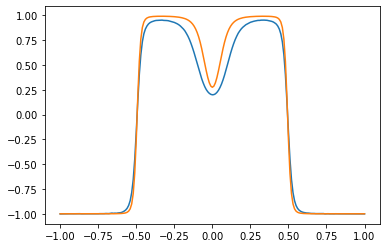

In [17]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 201).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 201).float()
        prediction_tensor[:, i+1, :] = prediction
        
print(prediction.shape)

final_out = prediction.detach().numpy().reshape(-1,1)
final_true = u[-1,:].reshape(-1,1)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

### error at final time

In [18]:
# Convert NumPy arrays to PyTorch tensors
final_out_tensor = torch.from_numpy(final_out)
final_true_tensor = torch.from_numpy(final_true)
# final_true_tensor = torch.abs(final_true_tensor)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((final_out_tensor - final_true_tensor)**2)/torch.mean(final_true_tensor**2)
print("Relative Error Test: ", relative_error_test.item(), "")

Relative Error Test:  0.01426507959435885 


### Error in whole testing dataset

In [19]:
# exact
u_test = u
u_test_full = u_test[80:100, :]

In [20]:
u_test_full.shape

(20, 201)

In [21]:
prediction_tensor.shape

torch.Size([1, 20, 201])

### L2 norm 

### Changed prediction tensor

In [22]:

k1 = (prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
u_test_full_tensor.shape

torch.Size([20, 201])

In [23]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.004932424534439651 %


### Max absolute error

In [24]:
R_abs = torch.max(prediction-u_test_full)

In [25]:
R_abs

tensor(0.1376, dtype=torch.float64)

### mean absolute error

In [26]:
R_mean = torch.mean(torch.abs(prediction - u_test_full))

In [27]:
R_mean

tensor(0.0348, dtype=torch.float64)

### Explained variance error

In [28]:
import torch

a = prediction
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())


Explained Variance Score: 0.9956219130806301


### Contour plot 80 PINN and 20 LEM solution

In [29]:
prediction_tensor = torch.squeeze(prediction_tensor)
prediction_tensor.shape

torch.Size([20, 201])

In [30]:
prediction.shape

torch.Size([1, 1, 201])

In [31]:
input_tensor.shape

torch.Size([1, 80, 201])

In [32]:
conc_u = torch.squeeze(input_tensor)
prediction_tensor = torch.squeeze(prediction_tensor)

In [33]:
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

concatenated_tensor.shape

torch.Size([100, 201])

In [34]:
t1 = np.linspace(0, 1 , 100)

#### Snapshots at particular time
### t = 0.81, 0.99

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


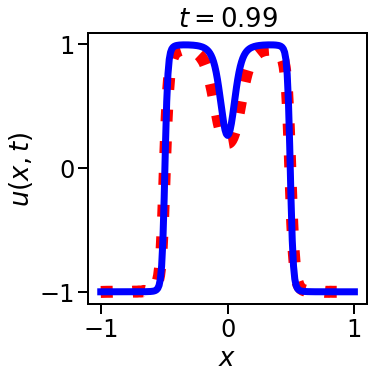

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u[-2, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.99}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.99_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


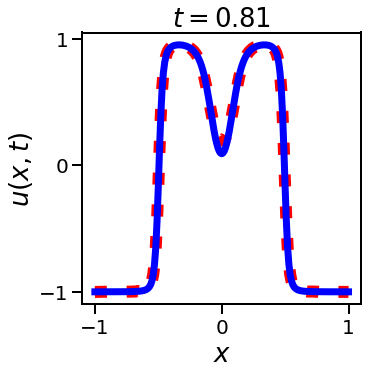

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Perform the prediction
with torch.no_grad():
    prediction = lem(test_tensor)

final_time_output = prediction_tensor[-20, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u[-20, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.81}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('LEM_0.81_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


### 80-20 (80 for PINN and 20 extrapolation using LEM)

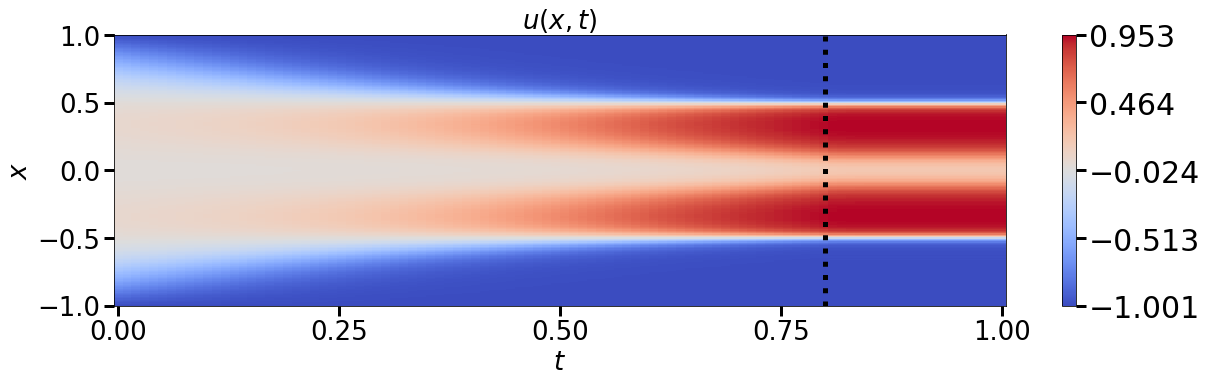

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(-1, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='coolwarm')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.8, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_LEM_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### exact solution contour

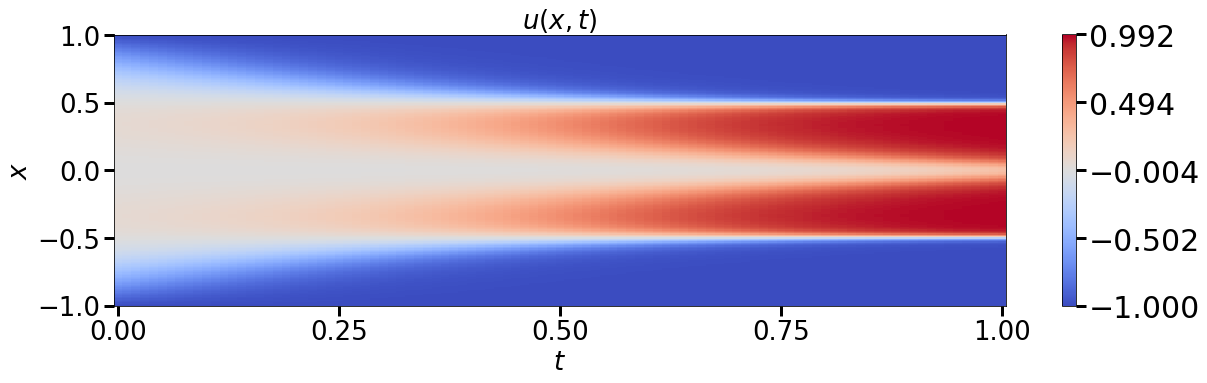

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = u

# Define custom color levels
x = np.linspace(-1, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='coolwarm')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

#plt.savefig('Contour_Exact.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_exact.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
